# Introduction

This notebook is intended to reproduce key results from the paper "Identification and machine learning prediction of knee-point and
knee-onset in capacity degradation curves of lithium-ion cells". 

The dataset used is available at https://data.matr.io/1/projects/5c48dd2bc625d700019f3204. For purposes of reducing space usage and computation time, we use only one batch of the dataset (2017-05-12). 

In particular, we look at the following:

1. (Sec 2.2) Identification of knee-point and knee-onset using the Bacon and Watts model, based on code available at https://github.com/pfermined/knee_identification. 

2. (Sec 2.3) Estimating the cycle life of a cell using a linear regression model.

3. (Sec 3 problem 1) Classifying cell lifecycles into short, medium, and long, based on the knee-point occurence. 

4. (Sec 3 problem 2) Predicting the knee-point and knee-onset using only information from the early life-cycle of the cell.

In [66]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

plt.style.use('seaborn')

## Data prep

### Defining functions

In [2]:
# Define bacon-watts formula
def bacon_watts_model(x, alpha0, alpha1, alpha2, x1):
    ''' Equation of bw_model'''
    return alpha0 + alpha1 * (x - x1) + \
            alpha2 * (x - x1) * np.tanh((x - x1) / 1e-8)


def fit_bacon_watts(y, p0):
    ''' Function to fit Bacon-Watts model to identify knee-point in capacity fade data
    
    Args:
    - capacity fade data (list): cycle-to-cycle evolution of Qd capacity
    - p0 (list): initial parameter values for Bacon-Watts model
    
    Returns:
    - popt (int): fitted parameters
    - confint (list): 95% confidence interval for fitted knee-point
    '''         
    
    # Define array of cycles
    x = np.arange(len(y)) + 1
    
    # Fit bacon-watts
    popt, pcov = curve_fit(bacon_watts_model, x, y, p0=p0)
    
    confint = [popt[3] - 1.96 * np.diag(pcov)[3], 
               popt[3] + 1.96 * np.diag(pcov)[3]]
    
    return popt, confint


def double_bacon_watts_model(x, alpha0, alpha1, alpha2, alpha3, x0, x2):
    return alpha0 + alpha1 * (x - x0) + \
             alpha2 * (x - x0) * np.tanh((x - x0)/1e-8) + \
             alpha3 * (x - x2) * np.tanh((x - x2)/1e-8)


def fit_double_bacon_watts(y, p0):
    ''' Function to fit Bacon-Watts model to identify knee-point in capacity fade data
    
    Args:
    - capacity fade data (list): cycle-to-cycle evolution of Qd capacity
    - p0 (list): initial parameter values for Bacon-Watts model
    
    Returns:
    - popt (int): fitted parameters
    - confint (list): 95% confidence interval for fitted knee-point
    ''' 
    
    # Define array of cycles
    x = np.arange(len(y)) + 1
    
    # Fit bacon-watts
    popt, pcov = curve_fit(double_bacon_watts_model, x, y, p0=p0)
    
    confint = [popt[4] - 1.96 * np.diag(pcov)[4], 
               popt[4] + 1.96 * np.diag(pcov)[4]]
    
    return popt, confint

### Checking file contents

In [3]:
battery = "b1c45"
fname = f'../data/interim/{battery}.pkl'

In [4]:
with open(fname, "rb") as openfile:
    fdict = pickle.load(openfile)

In [5]:
fdict.keys()

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])

In [6]:
fdict["cycle_life"]

array([[599.]])

In [7]:
fdict["charge_policy"]

'8C(35%)-3.6C'

In [8]:
fdict["summary"].keys()

dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])

In [9]:
fdict["cycles"]["1"].keys()

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

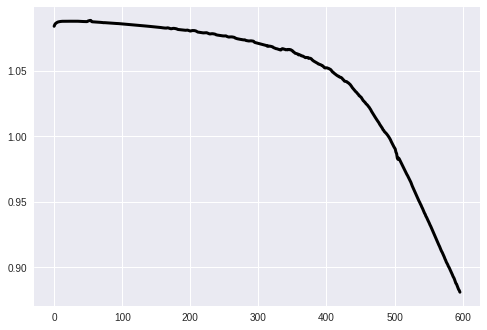

In [21]:
d = fdict["summary"]["QD"][1:]

plt.plot([x for x in range(len(d))], d, 'k-', linewidth=3)

## 2.2: Curve fitting: knee-point and knee-onset

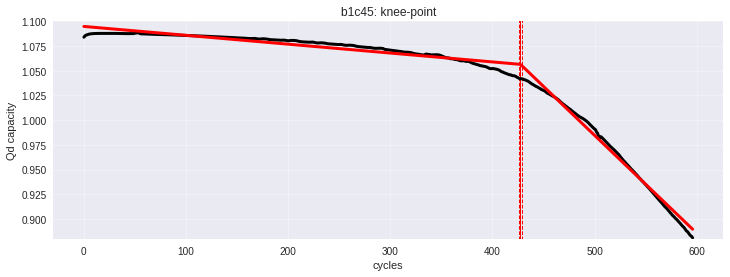

In [11]:
y_data = d
x_data = [x for x in range(len(d))]
p0 = [1, -1e-4, -1e-4, len(y_data)*.7]
popt_kpoint, confint = fit_bacon_watts(y_data, p0)

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(x_data, y_data, 'k-', linewidth=3)
plt.plot(x_data, bacon_watts_model(x_data, *popt_kpoint), 'r-', linewidth=3)
plt.vlines(popt_kpoint[3], 0, 2, color='red', linewidth=1)
plt.vlines(confint[0], 0, 2, color='red', linewidth=1, linestyle='--')
plt.vlines(confint[1], 0, 2, color='red', linewidth=1, linestyle='--')
plt.xlabel('cycles')
plt.ylabel('Qd capacity')
plt.grid(alpha=.3)
plt.ylim(.88, 1.1)
plt.title("b1c45: knee-point")
plt.show()


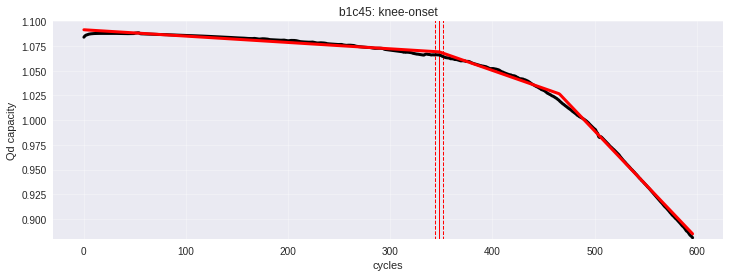

In [12]:
popt = popt_kpoint # Setting of popt is missing in original notebook
p0 = [popt[0], popt[1] + popt[2]/2, popt[2], popt[2]/2, .8*popt[3], 1.1*popt[3]]
popt_konset, confint = fit_double_bacon_watts(y_data, p0)


# Plot results
x_data = [x for x in range(len(d))]
plt.figure(figsize=(12, 4))
plt.plot(x_data, y_data, 'k-', linewidth=3)
plt.plot(x_data, double_bacon_watts_model(x_data, *popt_konset), 'r-', linewidth=3)
plt.vlines(popt_konset[4], 0, 2, color='red', linewidth=1)
plt.vlines(confint[0], 0, 2, color='red', linewidth=1, linestyle='--')
plt.vlines(confint[1], 0, 2, color='red', linewidth=1, linestyle='--')
plt.xlabel('cycles')
plt.ylabel('Qd capacity')
plt.grid(alpha=.3)
plt.ylim(.88, 1.1)
plt.title("b1c45: knee-onset")
plt.show()

## 2.3: Linear regression for estimating life cycle, knees

### Using parameters from paper

In [13]:
def estimate_cycle_life(X, param_dict):
    return param_dict["beta_0"] + (param_dict["beta_1"] * X)

def estimate_knee(Y, param_dict):
    return (Y - param_dict["beta_0"]) / param_dict["beta_1"]

In [14]:
# Parameters given in table 1 of the paper
# Knee-onset 
knee_onset_params = {"beta_0": 72.13, "beta_1": 1.44}
# Knee-point
knee_point_params = {"beta_0": 25.57, "beta_1": 1.26}

In [15]:
# Knee-point
y_data = d
x_data = [x for x in range(len(d))]
p0 = [1, -1e-4, -1e-4, len(y_data)*.7]
popt_kpoint, confint = fit_bacon_watts(y_data, p0)
knee_point = popt_kpoint[3]

predicted_cycle_life = estimate_cycle_life(knee_point, knee_point_params)
cycle_life = fdict["cycle_life"][0][0]

print("Using knee-point:")
print(f"Predicted cycle life: {predicted_cycle_life}")
print(f"Actual cycle life: {cycle_life}\n")

predicted_knee_point = estimate_knee(cycle_life, knee_point_params) 
print(f"Predicted knee-point using cycle life: {predicted_knee_point}")
print(f"Actual knee-point: {knee_point}")

Using knee-point:
Predicted cycle life: 564.1666973930213
Actual cycle life: 599.0

Predicted knee-point using cycle life: 455.1031746031746
Actual knee-point: 427.4576963436677


In [16]:
# Knee-onset
popt = popt_kpoint 
p0 = [popt[0], popt[1] + popt[2]/2, popt[2], popt[2]/2, .8*popt[3], 1.1*popt[3]]
popt_konset, confint = fit_double_bacon_watts(y_data, p0)
knee_onset = popt_konset[4]

predicted_cycle_life = estimate_cycle_life(knee_onset, knee_onset_params)
cycle_life = fdict["cycle_life"][0][0]

print("Using knee-offset:")
print(f"Predicted cycle life: {predicted_cycle_life}")
print(f"Actual cycle life: {cycle_life}\n")

predicted_knee_onset = estimate_knee(cycle_life, knee_onset_params) 
print(f"Predicted knee-onset using cycle life: {predicted_knee_onset}")
print(f"Actual knee-onset: {knee_onset}")

Using knee-offset:
Predicted cycle life: 573.0579640818871
Actual cycle life: 599.0

Predicted knee-onset using cycle life: 365.88194444444446
Actual knee-onset: 347.8666417235328


### Estimating parameters for the batch

In [17]:
def read_cell(n):
    fname = f'../data/interim/b1c{n}.pkl'
    with open(fname, "rb") as openfile:
        fdict = pickle.load(openfile)

    cycle_life = fdict["cycle_life"][0][0]
    discharge = fdict["summary"]["QD"][1:]

    # Fit knee point
    p0 = [1, -1e-4, -1e-4, len(discharge)*.7]
    popt_kpoint, confint = fit_bacon_watts(discharge, p0)
    knee_point = popt_kpoint[3]

    # Fit knee offset
    popt = popt_kpoint
    p0 = [popt[0], popt[1] + popt[2]/2, popt[2], popt[2]/2, .8*popt[3], 1.1*popt[3]]
    popt_konset, confint = fit_double_bacon_watts(discharge, p0)
    knee_onset = popt_konset[4]
    
    return [n, cycle_life, knee_point, knee_onset]

In [18]:
cell_data = []

for i in range(0, 46):
    cell_data.append(read_cell(i))

In [59]:
df = pd.DataFrame(cell_data,
             columns = ["cell number", "cycle life", "knee point", "knee onset"])
df = df.set_index("cell number")
df.head()

,cycle life,knee point,knee onset
cell number,,,
0,1190.0,664.000008,463.026962
1,1179.0,405.599964,367.332226
2,1177.0,423.625460,351.318919
3,1226.0,960.921459,825.703712
4,1227.0,876.629448,352.305033


In [49]:
X_kp = df[["knee point"]]
y = df["cycle life"]
reg = LinearRegression().fit(X_kp, y)
beta_1_kp = reg.coef_[0]
beta_0_kp = reg.intercept_
print("For knee point,")
print(f"Beta 0: {beta_0_kp:.2f}")
print(f"Beta 1: {beta_1_kp:.2f}\n")

X_ko = df[["knee onset"]]
y = df["cycle life"]
reg = LinearRegression().fit(X_ko, y)
beta_1_ko = reg.coef_[0]
beta_0_ko = reg.intercept_
print("For knee onset,")
print(f"Beta 0: {beta_0_kp:.2f}")
print(f"Beta 1: {beta_1_kp:.2f}\n")

# Knee-onset 
knee_onset_params_batch1 = {"beta_0": beta_0_ko, "beta_1": beta_1_ko}
# Knee-point
knee_point_params_batch1 = {"beta_0": beta_0_kp, "beta_1": beta_1_kp}

For knee point,
Beta 0: 241.07
Beta 1: 0.99

For knee onset,
Beta 0: 241.07
Beta 1: 0.99



### Comparison of our fit and paper parameters

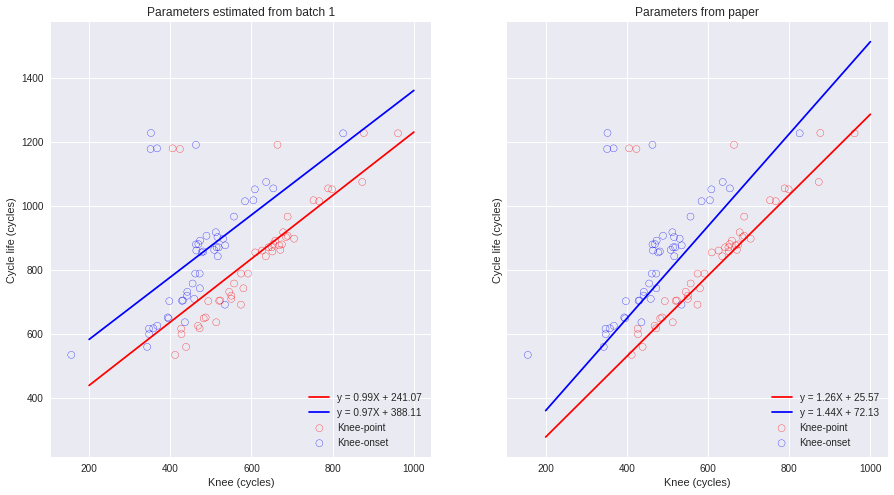

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8), sharey = True)
x = np.linspace(200, 1000)

# Fit to batch 1 
beta_0_kp = knee_point_params_batch1["beta_0"]
beta_1_kp = knee_point_params_batch1["beta_1"]
beta_0_ko = knee_onset_params_batch1["beta_0"]
beta_1_ko = knee_onset_params_batch1["beta_1"]

y_kp = beta_0_kp + (beta_1_kp * x)
y_ko = beta_0_ko + (beta_1_ko * x)

ax1.plot(x, y_kp, '-r',
         label = f"y = {beta_1_kp:.2f}X + {beta_0_kp:.2f}")
ax1.scatter(x = X_kp, y = y, facecolors = 'none', edgecolors = 'r',
           label = "Knee-point")

ax1.plot(x, y_ko, '-b', 
         label = f"y = {beta_1_ko:.2f}X + {beta_0_ko:.2f}")
ax1.scatter(x = X_ko, y = y, facecolors = 'none', edgecolors = 'b',
           label = "Knee-onset")

ax1.set_xlabel("Knee (cycles)")
ax1.set_ylabel("Cycle life (cycles)")
ax1.set_title("Parameters estimated from batch 1")
ax1.legend(loc = 'lower right')

# Fit from paper
beta_0_kp = knee_point_params["beta_0"]
beta_1_kp = knee_point_params["beta_1"]
beta_0_ko = knee_onset_params["beta_0"]
beta_1_ko = knee_onset_params["beta_1"]

y_kp = beta_0_kp + (beta_1_kp * x)
y_ko = beta_0_ko + (beta_1_ko * x)

ax2.plot(x, y_kp, '-r',
         label = f"y = {beta_1_kp:.2f}X + {beta_0_kp:.2f}")
ax2.scatter(x = X_kp, y = y, facecolors = 'none', edgecolors = 'r',
           label = "Knee-point")


ax2.plot(x, y_ko, '-b', 
         label = f"y = {beta_1_ko:.2f}X + {beta_0_ko:.2f}")
ax2.scatter(x = X_ko, y = y, facecolors = 'none', edgecolors = 'b',
           label = "Knee-onset")

ax2.set_xlabel("Knee (cycles)")
ax2.set_ylabel("Cycle life (cycles)")
ax2.set_title("Parameters from paper")

ax2.legend(loc = 'lower right')

plt.show()

### Calculating RMSE

In [60]:
fit_df = df.copy(deep = True)
fit_df["cycle_kp_b1"] = knee_point_params_batch1["beta_0"] + knee_point_params_batch1["beta_1"] * fit_df["knee point"]
fit_df["cycle_kp_paper"] = knee_point_params["beta_0"] + knee_point_params["beta_1"] * fit_df["knee point"]

fit_df["cycle_ko_b1"] = knee_onset_params_batch1["beta_0"] + knee_onset_params_batch1["beta_1"] * fit_df["knee onset"]
fit_df["cycle_ko_paper"] = knee_onset_params["beta_0"] + knee_onset_params["beta_1"] * fit_df["knee onset"]
fit_df.head()

,cycle life,knee point,knee onset,cycle_kp_b1,cycle_kp_paper,cycle_ko_b1,cycle_ko_paper
cell number,,,,,,,
0,1190.0,664.000008,463.026962,897.618266,862.210010,838.091908,738.888826
1,1179.0,405.599964,367.332226,642.116338,536.625955,745.094051,601.088405
2,1177.0,423.625460,351.318919,659.939666,559.338080,729.532033,578.029243
3,1226.0,960.921459,825.703712,1191.209560,1236.331038,1190.547662,1261.143345
4,1227.0,876.629448,352.305033,1107.862936,1130.123105,730.490357,579.449248


In [67]:
mse_kp_b1 = math.sqrt(mean_squared_error(fit_df["cycle life"], fit_df["cycle_kp_b1"]))
mse_kp_paper = math.sqrt(mean_squared_error(fit_df["cycle life"], fit_df["cycle_kp_paper"]))

print("RMSE based on knee point: ")
print(f"Batch 1 estimate: {mse_kp_b1}")
print(f"Paper parameters: {mse_kp_paper}")


mse_ko_b1 = math.sqrt(mean_squared_error(fit_df["cycle life"], fit_df["cycle_ko_b1"]))
mse_ko_paper = math.sqrt(mean_squared_error(fit_df["cycle life"], fit_df["cycle_ko_paper"]))

print("RMSE based on knee onset: ")
print(f"Batch 1 estimate: {mse_ko_b1}")
print(f"Paper parameters: {mse_ko_paper}")

RMSE based on knee point: 
Batch 1 estimate: 130.27960396883125
Paper parameters: 143.86299326038508
RMSE based on knee onset: 
Batch 1 estimate: 151.9711464805202
Paper parameters: 186.2597856006922
